## Demonstração Graph Neural Networks

In [6]:
# ganrante que as bibliotecas necessárias estrão disponíveis no jupyter
%conda install -c pytorch pytorch torchvision
%conda install pyg -c pyg -c conda-forge

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.
Solving environment: done

## Package Plan ##

  environment location: /home/thiago/anaconda3

  added / updated specs:
    - pyg


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.10.3               |   py38h578d9bd_2         3.0 MB  conda-forge
    googledrivedownloader-0.4  |     pyhd3deb0d_1           7 KB  conda-forge
    pyg-2.0.2                  |py38_torch_1.10.0_cu102         631 KB  pyg
    python-louvain-0.15        |     pyhd3deb0d_0          12 KB  conda-forge
    pytorch-cluster-1.5.9      |py38_torch_1.10.0_cu102         904 KB  pyg
    pytorch-scatter-2.0.9      |py38_torch_1.10.0_cu102         4.7 MB  pyg
    pytorch-sparse-0.6.12      |py38_torch_1.10.0_cu102         2.1 MB  pyg
    pytorch-spline-conv-1.2.1  |py38_torch_1.10

### Recursos básicos da Pytorch Geometric

In [59]:
#Somente para imprimir imagens locais no jupyter-notebook
from IPython import display

import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)
data

Data(x=[3, 1], edge_index=[2, 4])

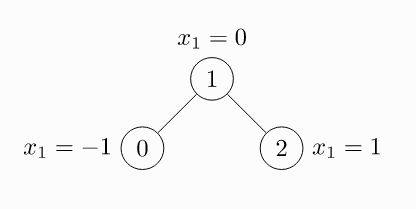

In [60]:
display.Image("imgs/grafosimples.png")

### O objeto Data

In [61]:
print(data.keys)

print()
print(data['x'])

print()
for key, item in data:
    print(key+" presente no grafo")

['x', 'edge_index']

tensor([[-1.],
        [ 0.],
        [ 1.]])

x presente no grafo
edge_index presente no grafo


In [62]:
print(data.num_nodes)

3


In [3]:
print(data.num_edges)


print(data.num_node_features)


print(data.has_isolated_nodes())


4
1
False


In [6]:
# Tranferir o objeto data para a GPU.
device = torch.device('cuda')
data = data.to(device)

### Datasets prontos disponíveis na Pytorch Geometric
Existem vários datasets já disponíveis. É útil olhar para esses "formatados", pois podemos entender como os nossos datasets podem estar depois de carregados apropriadamente.

In [5]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')
dataset

ENZYMES(600)

In [6]:
len(dataset)


600

In [7]:
dataset[0]

Data(edge_index=[2, 168], x=[37, 3], y=[1])

In [16]:
dataset.num_classes


6

In [17]:
dataset.num_node_features

3

In [13]:
#Se necessário, podemos embaralhar o dataset
dataset = dataset.shuffle()

In [14]:
#Podemos fatiar o dataset
train_dataset = dataset[:500]
train_dataset

ENZYMES(500)

In [15]:
test_dataset = dataset[500:]
test_dataset

ENZYMES(100)

### Exemplo de dataset com um único grafo
Este exemplo ilustra um grafo para os problemas de classificação de nós

In [9]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')
dataset

Cora()

In [10]:
print(len(dataset))

print(dataset.num_classes)

print(dataset.num_node_features)

1
7
1433


In [18]:
data = dataset[0]
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

Veja que tem os campos train_mask, val_mask e test_mask. Isso facilita a realização do treinamento e testes. <br>

In [19]:
print(data.train_mask.sum().item())

print(data.val_mask.sum().item())

print(data.test_mask.sum().item())

140
500
1000


train_mask: indica quais nós serão usados para treinar (140 nós)<br>

val_mask: nós para validação (500 nós),

test_mask: quais nós para testar (1000 nós).

### Mini-batches

Abordagem comum em redes neurais.

PyG contém seu próprio torch_geometric.loader.DataLoader, que já cuida desse processo.

In [25]:
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES', use_node_attr=True)
loader = DataLoader(dataset, batch_size=100, shuffle=True)

for batch in loader:
    print(batch)
    print(batch.num_graphs)
    
    #O atributo batch é um vetor que indica em que grafo cada nó pertence
    print(batch.batch)
    

DataBatch(edge_index=[2, 12062], x=[3199, 21], y=[100], batch=[3199], ptr=[101])
100
tensor([ 0,  0,  0,  ..., 99, 99, 99])
DataBatch(edge_index=[2, 12098], x=[3181, 21], y=[100], batch=[3181], ptr=[101])
100
tensor([ 0,  0,  0,  ..., 99, 99, 99])
DataBatch(edge_index=[2, 12428], x=[3249, 21], y=[100], batch=[3249], ptr=[101])
100
tensor([ 0,  0,  0,  ..., 99, 99, 99])
DataBatch(edge_index=[2, 12364], x=[3210, 21], y=[100], batch=[3210], ptr=[101])
100
tensor([ 0,  0,  0,  ..., 99, 99, 99])
DataBatch(edge_index=[2, 12600], x=[3326, 21], y=[100], batch=[3326], ptr=[101])
100
tensor([ 0,  0,  0,  ..., 99, 99, 99])
DataBatch(edge_index=[2, 13012], x=[3415, 21], y=[100], batch=[3415], ptr=[101])
100
tensor([ 0,  0,  0,  ..., 99, 99, 99])


O atributo batch nesse objeto acima é um vetor que indica em que grafo cada nó pertence

# Primeira GCN

In [63]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')
dataset


Cora()

### Define o modelo - usando uma GCN (Graph Convolution Network)
Este modelo visa prever a classe de um determinado nó

In [64]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

### Instância do modelo e treino

In [65]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,  weight_decay=5e-4)


model.train()

for epoch in range(1000):
    optimizer.zero_grad()
    out = model(data)
    
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    print(loss.item())

cuda
1.9467878341674805
1.9355218410491943
1.921411395072937
1.907836675643921
1.8967329263687134
1.8826631307601929
1.8714100122451782
1.856144666671753
1.8595712184906006
1.8292794227600098
1.8173669576644897
1.7960596084594727
1.793837308883667
1.7807165384292603
1.7624996900558472
1.728920817375183
1.7297978401184082
1.702613353729248
1.684909701347351
1.6729233264923096
1.6644445657730103
1.6539063453674316
1.6197911500930786
1.6140810251235962
1.5984255075454712
1.5798884630203247
1.548060417175293
1.5388152599334717
1.5458635091781616
1.498610258102417
1.5099527835845947
1.489545464515686
1.4689756631851196
1.4357341527938843
1.4311721324920654
1.4168801307678223
1.3760454654693604
1.3417479991912842
1.3731054067611694
1.3420567512512207
1.3300844430923462
1.3058937788009644
1.3005071878433228
1.277860403060913
1.2525439262390137
1.2566120624542236
1.2187998294830322
1.224665641784668
1.2034837007522583
1.1953208446502686
1.1665434837341309
1.1781706809997559
1.1560086011886597


0.07670948654413223
0.06948340684175491
0.07660390436649323
0.054722998291254044
0.07035963237285614
0.08656001091003418
0.07505828142166138
0.06700588762760162
0.06638293713331223
0.06317857652902603
0.06284555047750473
0.06690523773431778
0.08742665499448776
0.08199400454759598
0.059563975781202316
0.09186728298664093
0.06790531426668167
0.08087696880102158
0.06791532039642334
0.10194491595029831
0.0902557298541069
0.07325106859207153
0.05990366265177727
0.07124272733926773
0.07073567807674408
0.07185263931751251
0.0694717988371849
0.08313532918691635
0.07213036715984344
0.059142474085092545
0.05817675590515137
0.06310446560382843
0.07192075997591019
0.07435303181409836
0.05971919372677803
0.07496654987335205
0.05084991455078125
0.06317513436079025
0.054398395121097565
0.05213503539562225
0.08066413551568985
0.06750611215829849
0.0731574296951294
0.07619885355234146
0.0773710235953331
0.08129887282848358
0.07843761146068573
0.05774558708071709
0.0764961838722229
0.059873316437006
0.0

0.04186541587114334
0.05124534294009209
0.03814320266246796
0.038243234157562256
0.05580493062734604
0.06160861998796463
0.049163736402988434
0.02821393869817257
0.04852129891514778
0.031808942556381226
0.03678324818611145
0.049377575516700745
0.026541225612163544
0.036520201712846756
0.042909614741802216
0.04684627801179886
0.04992172494530678
0.03716209903359413
0.0462457612156868
0.03127414360642433
0.035708919167518616
0.047380294650793076
0.0445268340408802
0.028578298166394234
0.052184589207172394
0.04663683474063873
0.051812976598739624
0.03311019018292427
0.04958309605717659
0.03530464321374893
0.03325691446661949
0.05040210485458374
0.040966156870126724
0.045886337757110596
0.03991462662816048
0.04287309944629669
0.03335613012313843
0.027773087844252586
0.04748795926570892
0.042115576565265656
0.04760550335049629
0.03974761441349983
0.034785542637109756
0.04173411801457405
0.03749449923634529
0.03176550194621086
0.027531197294592857
0.04762059077620506
0.0372777096927166
0.029

### Teste

In [67]:
model.eval()

pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())

print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.8030


# Link prediction - com GAE (Graph AutoEncoder)

In [17]:
from torch import nn
import torch_geometric.transforms as T
import torch.optim as optim

from torch.nn import ReLU

dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

data.train_mask = data.val_mask = data.test_mask = None

transform = T.RandomLinkSplit(is_undirected=True,add_negative_train_samples=True,split_labels=True)
train_data, val_data, test_data = transform(data)
train_data = train_data.to(device)
val_data=val_data.to(device)
test_data = test_data.to(device)
test_data

Data(x=[2708, 1433], edge_index=[2, 8446], y=[2708], pos_edge_label=[1055], pos_edge_label_index=[2, 1055], neg_edge_label=[1055], neg_edge_label_index=[2, 1055])

### Define o encoder

In [18]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True) # cached apenas para transductive learning
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True) # cached apenas para transductive learning

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)
    

### Define o autoencoder

In [34]:
from torch_geometric.nn import GAE

# parâmetros
out_channels = 2
num_features = dataset.num_features
epochs = 100

# modelo
model = GAE(GCNEncoder(num_features, out_channels))
model = model.to(device)

print(model)

x = train_data.x.to(device)

train_pos_edge_index = train_data.pos_edge_label_index.to(device)

# inicialização o optimizador
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

GAE(
  (encoder): GCNEncoder(
    (conv1): GCNConv(1433, 4)
    (conv2): GCNConv(4, 2)
  )
  (decoder): InnerProductDecoder()
)


### Treino e teste

In [20]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    loss.backward()
    optimizer.step()
    
    return float(loss)


def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)



In [55]:
for epoch in range(1, epochs + 1):
    loss = train()

    auc, ap = test(val_data.pos_edge_label_index, val_data.neg_edge_label_index)
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))
    

Epoch: 001, AUC: 0.9103, AP: 0.9300
Epoch: 002, AUC: 0.9102, AP: 0.9301
Epoch: 003, AUC: 0.9096, AP: 0.9299
Epoch: 004, AUC: 0.9087, AP: 0.9295
Epoch: 005, AUC: 0.9078, AP: 0.9291
Epoch: 006, AUC: 0.9075, AP: 0.9289
Epoch: 007, AUC: 0.9075, AP: 0.9289
Epoch: 008, AUC: 0.9071, AP: 0.9285
Epoch: 009, AUC: 0.9069, AP: 0.9284
Epoch: 010, AUC: 0.9063, AP: 0.9280
Epoch: 011, AUC: 0.9062, AP: 0.9281
Epoch: 012, AUC: 0.9060, AP: 0.9282
Epoch: 013, AUC: 0.9060, AP: 0.9281
Epoch: 014, AUC: 0.9062, AP: 0.9283
Epoch: 015, AUC: 0.9061, AP: 0.9283
Epoch: 016, AUC: 0.9062, AP: 0.9284
Epoch: 017, AUC: 0.9057, AP: 0.9280
Epoch: 018, AUC: 0.9055, AP: 0.9279
Epoch: 019, AUC: 0.9053, AP: 0.9278
Epoch: 020, AUC: 0.9051, AP: 0.9274
Epoch: 021, AUC: 0.9052, AP: 0.9275
Epoch: 022, AUC: 0.9051, AP: 0.9272
Epoch: 023, AUC: 0.9050, AP: 0.9271
Epoch: 024, AUC: 0.9049, AP: 0.9269
Epoch: 025, AUC: 0.9049, AP: 0.9269
Epoch: 026, AUC: 0.9049, AP: 0.9268
Epoch: 027, AUC: 0.9050, AP: 0.9267
Epoch: 028, AUC: 0.9048, AP:

In [57]:
#Teste
auc, ap = test(test_data.pos_edge_label_index, test_data.neg_edge_label_index)
print('AUC: {:.4f}, AP: {:.4f}'.format( auc, ap))

AUC: 0.8820, AP: 0.9116


## Demonstração do Tensorboard

In [37]:
#!pip install tensorboard

In [39]:
from torch.utils.tensorboard import SummaryWriter

In [51]:
#Copiei as informações anteriores

# parâmetros 
out_channels = 64
num_features = dataset.num_features
epochs = 100

# modelo
model = GAE(GCNEncoder(num_features, out_channels))
model = model.to(device)

print(model)

x = train_data.x.to(device)

train_pos_edge_index = train_data.pos_edge_label_index.to(device)

# inicialização o optimizador
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

GAE(
  (encoder): GCNEncoder(
    (conv1): GCNConv(1433, 128)
    (conv2): GCNConv(128, 64)
  )
  (decoder): InnerProductDecoder()
)


In [52]:
#Local onde os experimentos serão salvos
writer = SummaryWriter('experimentos/modelo_GAE3_'+'64d_100_epochs')

In [53]:
for epoch in range(1, epochs + 1):
    loss = train()
    auc, ap = test(val_data.pos_edge_label_index, val_data.neg_edge_label_index)
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))
    
    
    writer.add_scalar('auc validation',auc,epoch) # nova linha
    writer.add_scalar('ap validation',ap,epoch)   # nova linha

Epoch: 001, AUC: 0.8033, AP: 0.8233
Epoch: 002, AUC: 0.7415, AP: 0.7593
Epoch: 003, AUC: 0.8567, AP: 0.8662
Epoch: 004, AUC: 0.8148, AP: 0.8273
Epoch: 005, AUC: 0.8076, AP: 0.8251
Epoch: 006, AUC: 0.8203, AP: 0.8401
Epoch: 007, AUC: 0.8275, AP: 0.8476
Epoch: 008, AUC: 0.8287, AP: 0.8486
Epoch: 009, AUC: 0.8289, AP: 0.8481
Epoch: 010, AUC: 0.8292, AP: 0.8476
Epoch: 011, AUC: 0.8300, AP: 0.8456
Epoch: 012, AUC: 0.8336, AP: 0.8449
Epoch: 013, AUC: 0.8435, AP: 0.8526
Epoch: 014, AUC: 0.8559, AP: 0.8642
Epoch: 015, AUC: 0.8654, AP: 0.8742
Epoch: 016, AUC: 0.8710, AP: 0.8797
Epoch: 017, AUC: 0.8750, AP: 0.8839
Epoch: 018, AUC: 0.8795, AP: 0.8881
Epoch: 019, AUC: 0.8843, AP: 0.8923
Epoch: 020, AUC: 0.8874, AP: 0.8951
Epoch: 021, AUC: 0.8915, AP: 0.8991
Epoch: 022, AUC: 0.8951, AP: 0.9031
Epoch: 023, AUC: 0.8979, AP: 0.9065
Epoch: 024, AUC: 0.8996, AP: 0.9085
Epoch: 025, AUC: 0.9011, AP: 0.9103
Epoch: 026, AUC: 0.9025, AP: 0.9121
Epoch: 027, AUC: 0.9037, AP: 0.9140
Epoch: 028, AUC: 0.9048, AP:

### Visualize as informações no TensorBoard
Abra o terminal e digite: tensorboard --logdir=NOME DO SEU DIRETORIO ONDE SALVOU OS EXPERIMENTOS